In [34]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load the json file to dataframe
with open('transaction-data-adhoc-analysis.json','r') as f:
    boom = pd.read_json(f)

#split several transactions of one buyer
def splititemlist(transaction_item):
    if ';' in transaction_item:
        itemlist = transaction_item.split(';')
        return itemlist
    else:
        return [transaction_item]
    
#split individual items through functions 'brand: item' and 'qty'
def brandanditem(indivitem):
    listofitems = indivitem.split(',')
    return (listofitems[0]) + ': ' + listofitems[1]
def qty(indivitem):
    listofitems = indivitem.split(',')
    return listofitems[2]

#vectorize function into 'boom' dataframe and preserve 'transaction_items' column
boom['transitemlist'] = boom.apply(lambda x: splititemlist(x['transaction_items']), axis=1)

#vectorize 'brand: item' and 'qty' functions
vecbrandanditem = np.vectorize(brandanditem)
vecquantity = np.vectorize(qty)

#use explode()  to extend the list into rows
transitemsexplode = boom['transitemlist'].explode()

#create dataframe
transitemsdf = pd.DataFrame()

#store the data into the 'transitemsdf' by vectorizing
transitemsdf['brand: item'] = vecbrandanditem(transitemsexplode)
transitemsdf['qty'] = vecquantity(transitemsexplode)

#get the number part only from 'qty' column
transitemsdf['qty'] = transitemsdf['qty'].str.replace(r'[^0-9]', '',regex=True)

#change 'qty' column into integers
transitemsdf["qty"] = transitemsdf["qty"].astype(str).astype(int)

#create dataframe to store products
boomdf = pd.DataFrame(transitemsdf['brand: item'].unique(), columns=['brand: item'])

#function that adds the transaction dates per item sold
def transdateitem(transitemlist,transaction_date):
    transaction_dates = []
    for i in transitemlist:
        transaction_dates.append(transaction_date)
    return transaction_dates

boom['transaction_date_list'] = boom.apply(lambda x:transdateitem(x['transitemlist'],x['transaction_date']),axis=1)

#add the exploded 'transaction_date_list' to the transitemsdf
transdatesexplode = boom['transaction_date_list'].explode(ignore_index=True)
transitemsdf['transaction_date'] = transdatesexplode

#split the 'transaction_date' to get the month value
transitemsdf[['year', 'month', 'date']] = transitemsdf['transaction_date'].str.split('/', expand=True)

#change 'year', 'month', and 'date' columns into int.
transitemsdf["year"] = transitemsdf["year"].astype(str).astype(int)
transitemsdf["month"] = transitemsdf["month"].astype(str).astype(int)
transitemsdf["date"] = transitemsdf["date"].astype(str).astype(int)

#get the individual price of each item
adf = pd.DataFrame()
def getitem(trans_item):
    if ';' not in trans_item and '(x1)' in trans_item:
        return trans_item
adf['brand: item']=boom.apply(lambda x:getitem(x['transaction_items']),axis=1)
def getitemprice(trans_item, cost):
    if ';' not in trans_item and '(x1)' in trans_item:
        return cost
adf['indiv. price']=boom.apply(lambda x:getitemprice(x['transaction_items'],x['transaction_value']),axis=1)
adf.dropna(inplace=True)
adf = adf.drop_duplicates(keep='first')
adf['brand: item'] = adf.apply(lambda x:brandanditem(x['brand: item']),axis=1)

#join the two columns based on their unique values
boomdf = pd.merge(boomdf,adf, how='inner')

boomdf

,brand: item,indiv. price
0,Exotic Extras: Beef Chicharon,1299.0
1,HealthyKid 3+: Nutrional Milk,1990.0
2,Candy City: Orange Beans,199.0
3,HealthyKid 3+: Gummy Vitamins,1500.0
4,HealthyKid 3+: Yummy Vegetables,500.0
5,Candy City: Gummy Worms,150.0
6,Exotic Extras: Kimchi and Seaweed,799.0


In [35]:
#get the quantity of each item for every month
months = ['Jan','Feb','Mar','Apr','May','Jun']
blist = list(boomdf['brand: item'])
for element in range(len(months)):
    numberofitemsmonthlist = []
    for elem in range(len(blist)):
        # outputs count of each item
        numberofitemsmonth = transitemsdf.loc[(transitemsdf['brand: item'] == blist[elem]) & (transitemsdf['month']== element+1), 'qty'].sum()
        numberofitemsmonthlist.append(numberofitemsmonth)
    boomdf[f'{months[element]} Total']= numberofitemsmonthlist

#total sale per month
def salesofitemmonth(number, indivprice):
    return number * indivprice

for a in range(len(months)):
  boomdf[f'{months[a]} Sales']=boomdf.apply(lambda x:salesofitemmonth(x[f'{months[a]} Total'],x['indiv. price']), axis=1)
boomdf

,brand: item,indiv. price,Jan Total,Feb Total,Mar Total,Apr Total,May Total,Jun Total,Jan Sales,Feb Sales,Mar Sales,Apr Sales,May Sales,Jun Sales
0,Exotic Extras: Beef Chicharon,1299.0,9665,10001,9816,9890,10028,9902,12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0
1,HealthyKid 3+: Nutrional Milk,1990.0,9727,9691,9876,9786,9881,9767,19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0
2,Candy City: Orange Beans,199.0,9774,10037,9611,9914,9964,10106,1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0
3,HealthyKid 3+: Gummy Vitamins,1500.0,9681,9980,10145,9842,9948,9980,14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0
4,HealthyKid 3+: Yummy Vegetables,500.0,9959,10256,9896,9861,9735,9722,4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0
5,Candy City: Gummy Worms,150.0,9559,9996,9986,10043,9801,9934,1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0
6,Exotic Extras: Kimchi and Seaweed,799.0,9676,9949,9967,9921,9773,10104,7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0


In [36]:
#create table of count of each item sold per month
totalitemssold = pd.pivot_table(boomdf, values=['Jan Total','Feb Total','Mar Total','Apr Total','May Total','Jun Total'],index=['brand: item'])
totalitemssold = totalitemssold.reindex(['Jan Total','Feb Total','Mar Total','Apr Total','May Total','Jun Total'], axis=1)
totalitemssold.reset_index(inplace=True)
totalitemssold

,brand: item,Jan Total,Feb Total,Mar Total,Apr Total,May Total,Jun Total
0,Candy City: Gummy Worms,9559,9996,9986,10043,9801,9934
1,Candy City: Orange Beans,9774,10037,9611,9914,9964,10106
2,Exotic Extras: Beef Chicharon,9665,10001,9816,9890,10028,9902
3,Exotic Extras: Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
4,HealthyKid 3+: Gummy Vitamins,9681,9980,10145,9842,9948,9980
5,HealthyKid 3+: Nutrional Milk,9727,9691,9876,9786,9881,9767
6,HealthyKid 3+: Yummy Vegetables,9959,10256,9896,9861,9735,9722


In [37]:
#create table showing the trend of quantity sold of each item for six months
totis = {'Months':['Jan Total','Feb Total','Mar Total','Apr Total','May Total','Jun Total'], 'Candy City: Gummy Worms':[9559,9996,9986,10043,9801,9934], 'Candy City: Orange Beans':[9774,10037,9611,9914,9964,10106], 'Exotic Extras: Beef Chicharon':[9665,10001,9816,9890,10028,9902], 'Exotic Extras: Kimchi and Seaweed':[9676,9949,9967,9921,9773,10104], 'HealthyKid 3+: Gummy Vitamins':[9681,9980,10145,9842,9948,9980], 'HealthyKid 3+: Nutrional Milk':[9727,9691,9876,9786,9881,9767], 'HealthyKid 3+: Yummy Vegetables':[9959,10256,9896,9861,9735,9722]}
totisoldrev = pd.DataFrame(data=totis)
totisoldrev

,Months,Candy City: Gummy Worms,Candy City: Orange Beans,Exotic Extras: Beef Chicharon,Exotic Extras: Kimchi and Seaweed,HealthyKid 3+: Gummy Vitamins,HealthyKid 3+: Nutrional Milk,HealthyKid 3+: Yummy Vegetables
0,Jan Total,9559,9774,9665,9676,9681,9727,9959
1,Feb Total,9996,10037,10001,9949,9980,9691,10256
2,Mar Total,9986,9611,9816,9967,10145,9876,9896
3,Apr Total,10043,9914,9890,9921,9842,9786,9861
4,May Total,9801,9964,10028,9773,9948,9881,9735
5,Jun Total,9934,10106,9902,10104,9980,9767,9722


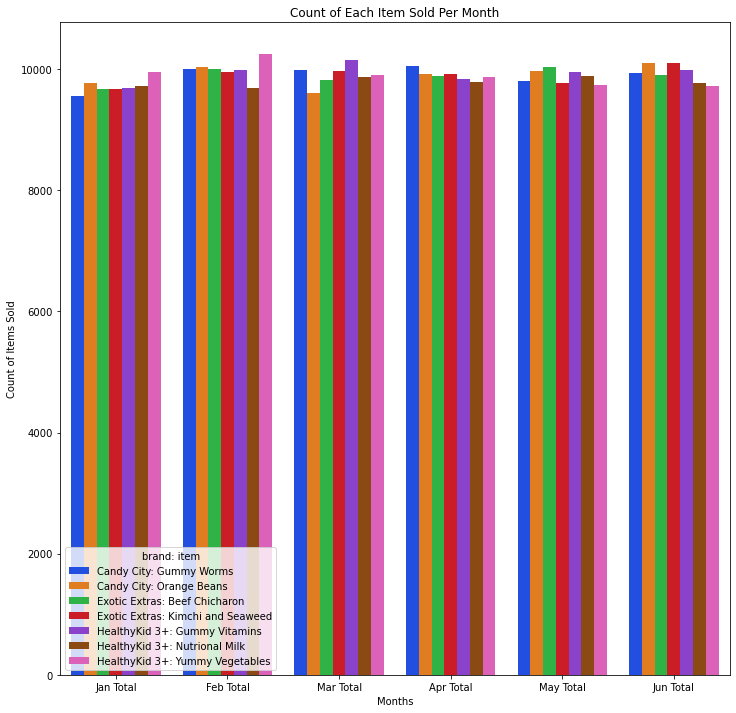

In [38]:
#create a bar graph for the count of each item sold per month
qty_sold_for_plot = totalitemssold.melt('brand: item',var_name='Months', value_name='Count of Items Sold')
plt.figure(figsize=(12,12))
plt.title('Count of Each Item Sold Per Month')
sns.barplot(x='Months', y='Count of Items Sold', hue='brand: item', data=qty_sold_for_plot, palette='bright')
plt.legend(title='brand: item', loc='lower left')
plt.savefig('countpermonth.jpg', bbox_inches='tight')

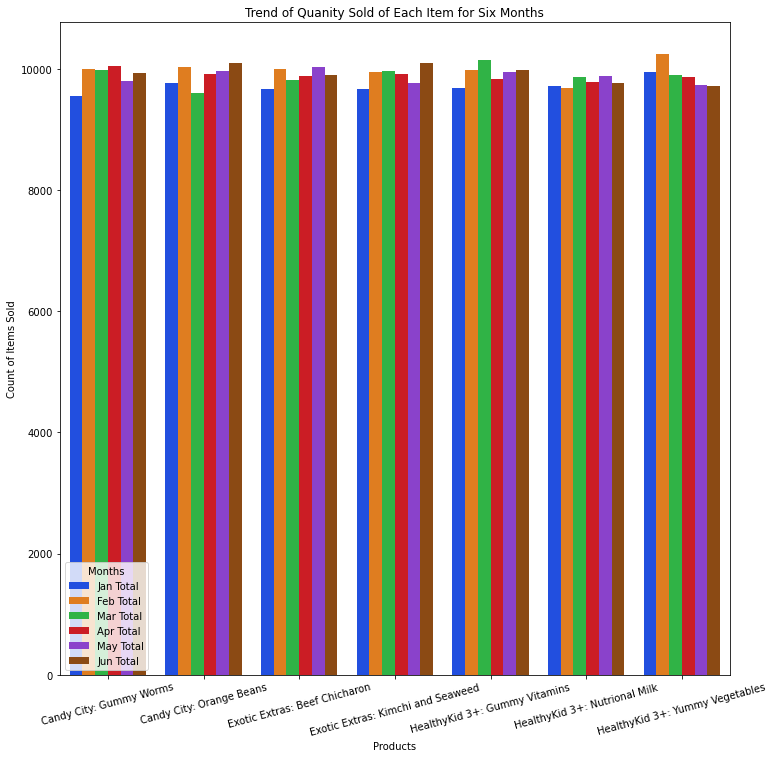

In [39]:
#make a bar graph showing the trend of quantity sold of each item for six months
qty_sold_for_plot_rev = totisoldrev.melt('Months',var_name='Products', value_name='Count of Items Sold')
plt.figure(figsize=(12,12))
plt.title('Trend of Quanity Sold of Each Item for Six Months')
sns.barplot(x='Products', y='Count of Items Sold', hue='Months', data=qty_sold_for_plot_rev, palette='bright')
plt.xticks(rotation=15)
plt.legend(title='Months', loc='lower left')
plt.savefig('trendquantitypermonth.jpg', bbox_inches='tight')

In [40]:
#create the table of total sale value of each item per month
totalsales = pd.pivot_table(boomdf, values=['Jan Sales','Feb Sales','Mar Sales','Apr Sales','May Sales','Jun Sales'],index=['brand: item'])
totalsales = totalsales.reindex(['Jan Sales','Feb Sales','Mar Sales','Apr Sales','May Sales','Jun Sales'], axis=1)
totalsales.reset_index(inplace=True)
totalsales

,brand: item,Jan Sales,Feb Sales,Mar Sales,Apr Sales,May Sales,Jun Sales
0,Candy City: Gummy Worms,1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0
1,Candy City: Orange Beans,1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0
2,Exotic Extras: Beef Chicharon,12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0
3,Exotic Extras: Kimchi and Seaweed,7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0
4,HealthyKid 3+: Gummy Vitamins,14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0
5,HealthyKid 3+: Nutrional Milk,19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0
6,HealthyKid 3+: Yummy Vegetables,4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0


In [41]:
#create table for sale value trend of each item for six months
totisales = {'Months':['Jan Sales','Feb Sales','Mar Sales','Apr Sales','May Sales','Jun Sales'], 'Candy City: Gummy Worms':[1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0], 'Candy City: Orange Beans':[1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0], 'Exotic Extras: Beef Chicharon':[12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0], 'Exotic Extras: Kimchi and Seaweed':[7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0], 'HealthyKid 3+: Gummy Vitamins':[14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0], 'HealthyKid 3+: Nutrional Milk':[19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0], 'HealthyKid 3+: Yummy Vegetables':[4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0]}
totisalesrev = pd.DataFrame(data=totisales)
totisalesrev

,Months,Candy City: Gummy Worms,Candy City: Orange Beans,Exotic Extras: Beef Chicharon,Exotic Extras: Kimchi and Seaweed,HealthyKid 3+: Gummy Vitamins,HealthyKid 3+: Nutrional Milk,HealthyKid 3+: Yummy Vegetables
0,Jan Sales,1433850.0,1945026.0,12554835.0,7731124.0,14521500.0,19356730.0,4979500.0
1,Feb Sales,1499400.0,1997363.0,12991299.0,7949251.0,14970000.0,19285090.0,5128000.0
2,Mar Sales,1497900.0,1912589.0,12750984.0,7963633.0,15217500.0,19653240.0,4948000.0
3,Apr Sales,1506450.0,1972886.0,12847110.0,7926879.0,14763000.0,19474140.0,4930500.0
4,May Sales,1470150.0,1982836.0,13026372.0,7808627.0,14922000.0,19663190.0,4867500.0
5,Jun Sales,1490100.0,2011094.0,12862698.0,8073096.0,14970000.0,19436330.0,4861000.0


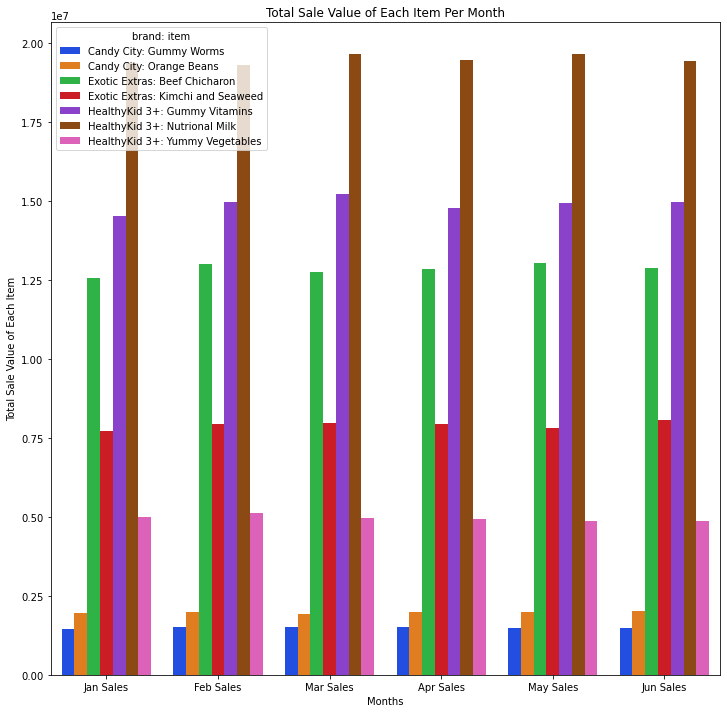

In [42]:
#create bar graph for total sale value of each item per month
qt = totalsales.melt('brand: item',var_name='Months', value_name='Total Sale Value of Each Item')
plt.figure(figsize=(12,12))
plt.title('Total Sale Value of Each Item Per Month')
sns.barplot(x='Months', y='Total Sale Value of Each Item', hue='brand: item', data=qt, palette='bright')
plt.legend(title='brand: item', loc='upper left')
plt.savefig('totalpermonth.jpg', bbox_inches='tight')

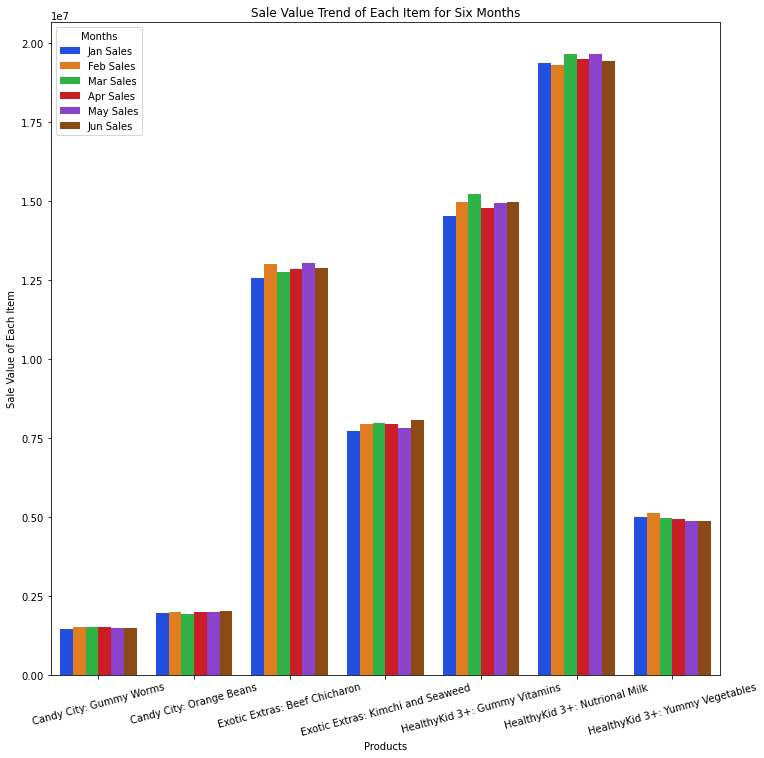

In [43]:
#create bar graph for sale value trend of each item for six months
qty_sales_for_plot_rev = totisalesrev.melt('Months',var_name='Products', value_name='Sale Value of Each Item')
plt.figure(figsize=(12,12))
plt.title('Sale Value Trend of Each Item for Six Months')
sns.barplot(x='Products', y='Sale Value of Each Item', hue='Months', data=qty_sales_for_plot_rev, palette='bright')
plt.xticks(rotation=15)
plt.legend(title='Months', loc='upper left')
plt.savefig('saletrendpermonth.jpg', bbox_inches='tight')